<a href="https://colab.research.google.com/github/naguzmans/opportunistic-atm/blob/master/05_ConvLSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data Arrays

In [ ]:
import numpy as np
%cd /content/drive/MyDrive/opportunistic-utm

/content/drive/MyDrive/opportunistic-utm


In [ ]:
# Load flight array as a stream
flights_array = np.load(f'dataset/00_results/flights_array_masked_273.npy', mmap_mode='r')
flights_array.shape

(273, 24, 100, 100, 20)

In [ ]:
# Load metadata array
metadata_array = np.load(f'dataset/00_results/metadata_array_273.npy')
metadata_array.shape

(273, 24, 25)

In [ ]:
# Load average flights array
flights_average = np.load(f'dataset/00_results/flights_average_273.npy')
flights_average.shape

(100, 100, 20)

# Define SARMSE Metric

In [ ]:
# Spatially Averaged Root Mean Square
def SARMSE(original, predicted):
  layer_rmse = np.sqrt(np.sum(np.square(original-predicted)/100**2, axis=(0,1)))
  return np.sum(layer_rmse)/original.shape[-1] # divided by # of channels

In [ ]:
# Check SARMSE on 100 random hours
import random

sum = 0
random_days = random.sample(range(flights_array.shape[0]), 10)
print(f'Random Days: {random_days}')
for i in random_days:
  random_hours = random.sample(range(flights_array.shape[1]), 10)
  print(f'Random Hours: {random_hours}')
  for j in random_hours:
    sum += SARMSE(flights_array[i, j, :, :, :], flights_average)

print(f'SARMSE: {sum/100}')

Random Days: [153, 69, 222, 58, 91, 194, 173, 253, 174, 67]
Random Hours: [16, 0, 5, 7, 1, 17, 4, 2, 15, 22]
Random Hours: [2, 7, 23, 0, 13, 9, 22, 18, 5, 20]
Random Hours: [8, 19, 1, 14, 17, 20, 10, 9, 4, 22]
Random Hours: [20, 12, 1, 16, 3, 22, 7, 4, 0, 18]
Random Hours: [13, 2, 18, 15, 11, 8, 16, 6, 5, 21]
Random Hours: [1, 6, 14, 23, 5, 3, 21, 16, 0, 9]
Random Hours: [12, 11, 16, 4, 0, 19, 7, 14, 13, 18]
Random Hours: [9, 7, 6, 23, 5, 12, 15, 13, 2, 10]
Random Hours: [9, 8, 23, 13, 22, 7, 18, 5, 12, 15]
Random Hours: [22, 10, 20, 14, 3, 12, 13, 18, 23, 21]
SARMSE: 0.07763271652263472


# Create x_train and y_train arrays

**Shifting functions**

In [ ]:
# This allows to shift the dataset by a specified timestep
def shift_flights_array(data, shift=1):
  x = data[:, 0 : data.shape[1] - shift, :, :]
  y = data[:, shift : data.shape[1], :, :]
  return x, y

def shift_metadata_array(data, shift=1):
  x = data[:, 0 : data.shape[1] - shift, :]
  y = data[:, shift : data.shape[1], :]
  return x, y

**Data Split**

In [ ]:
# Split
train = [0, 230]
val = [230, 260]
test = [260, 270]

**Shift flights array**

In [ ]:
shift = 1 # hours

x_train, y_train = shift_flights_array(flights_array[train[0]:train[1]], shift=shift)
x_val, y_val = shift_flights_array(flights_array[val[0]:val[1]], shift=shift)
x_test = flights_array[test[0]:test[1]]
print(f'x_train shape: {x_train.shape} / y_train shape: {y_train.shape}')
print(f'x_val shape: {x_val.shape} / y_val shape: {y_val.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (230, 23, 100, 100, 20) / y_train shape: (230, 23, 100, 100, 20)
x_val shape: (30, 23, 100, 100, 20) / y_val shape: (30, 23, 100, 100, 20)
x_test shape: (10, 24, 100, 100, 20)


**Shifts metadata array**

In [ ]:
x_mtrain, y_mtrain = shift_metadata_array(metadata_array[train[0]:train[1]], shift=shift)
x_mval, y_mval = shift_metadata_array(metadata_array[val[0]:val[1]], shift=shift)
x_mtest = metadata_array[test[0]:test[1]]
print(f'x_mtrain shape: {x_mtrain.shape} / y_mtrain shape: {y_mtrain.shape}')
print(f'x_mval shape: {x_mval.shape} / y_mval shape: {y_mval.shape}')
print(f'x_mtest shape: {x_test.shape}')

x_mtrain shape: (230, 23, 25) / y_mtrain shape: (230, 23, 25)
x_mval shape: (30, 23, 25) / y_mval shape: (30, 23, 25)
x_mtest shape: (10, 24, 100, 100, 20)


# ConvLSTM Model

**Dependencies**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, GRU, Dropout, TimeDistributed, MaxPooling3D

**Custom Keras Loss Function**

In [ ]:
from keras import backend as K

def custom_sarmse(y_true, y_pred):
  print(f'True shape: {y_true.shape}')
  print(f'Pred shape: {y_pred.shape}')
  a = K.square(y_true - y_pred + 1e-10)
  b = K.sum(a, [2,3], keepdims=True)
  c = K.sqrt(b)
  d = K.sum(c)/(100*20)
  return d

**Model**

In [ ]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))
minp = layers.Input(shape=(None, *x_mtrain.shape[2:]))

def repeat_tabular(x_tab):
  h = x_tab[:, :, :, None, None]
  h = tf.tile(h, [1, 1, 4, 100, 1]) 
  return h

a = layers.ConvLSTM2D(
    filters=32,
    kernel_size=(3, 3),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

b = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

c = layers.ConvLSTM2D(
    filters=16,
    kernel_size=(1, 1),
    dilation_rate=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
    data_format='channels_last'
)(inp)

y = tf.keras.layers.LSTM(64, return_sequences=True)(minp)
y = layers.Lambda(repeat_tabular)(minp)

x = tf.keras.layers.Concatenate()([a, b, c, y])
x = TimeDistributed(layers.BatchNormalization())(x)
x = TimeDistributed(layers.Dropout(0.1))(x)

x = layers.ConvLSTM2D(
    filters=20,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="sigmoid",
    data_format='channels_last'
)(x)

model = keras.models.Model(inputs = [inp, minp], outputs = x)
model.compile(
    loss=custom_sarmse, optimizer=keras.optimizers.Adam(),
)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None, 100,   0           []                               
                                100, 20)]                                                         
                                                                                                  
 input_6 (InputLayer)           [(None, None, 25)]   0           []                               
                                                                                                  
 conv_lstm2d_8 (ConvLSTM2D)     (None, None, 100, 1  60032       ['input_5[0][0]']                
                                00, 32)                                                           
                                                                                            

**Visualize model**

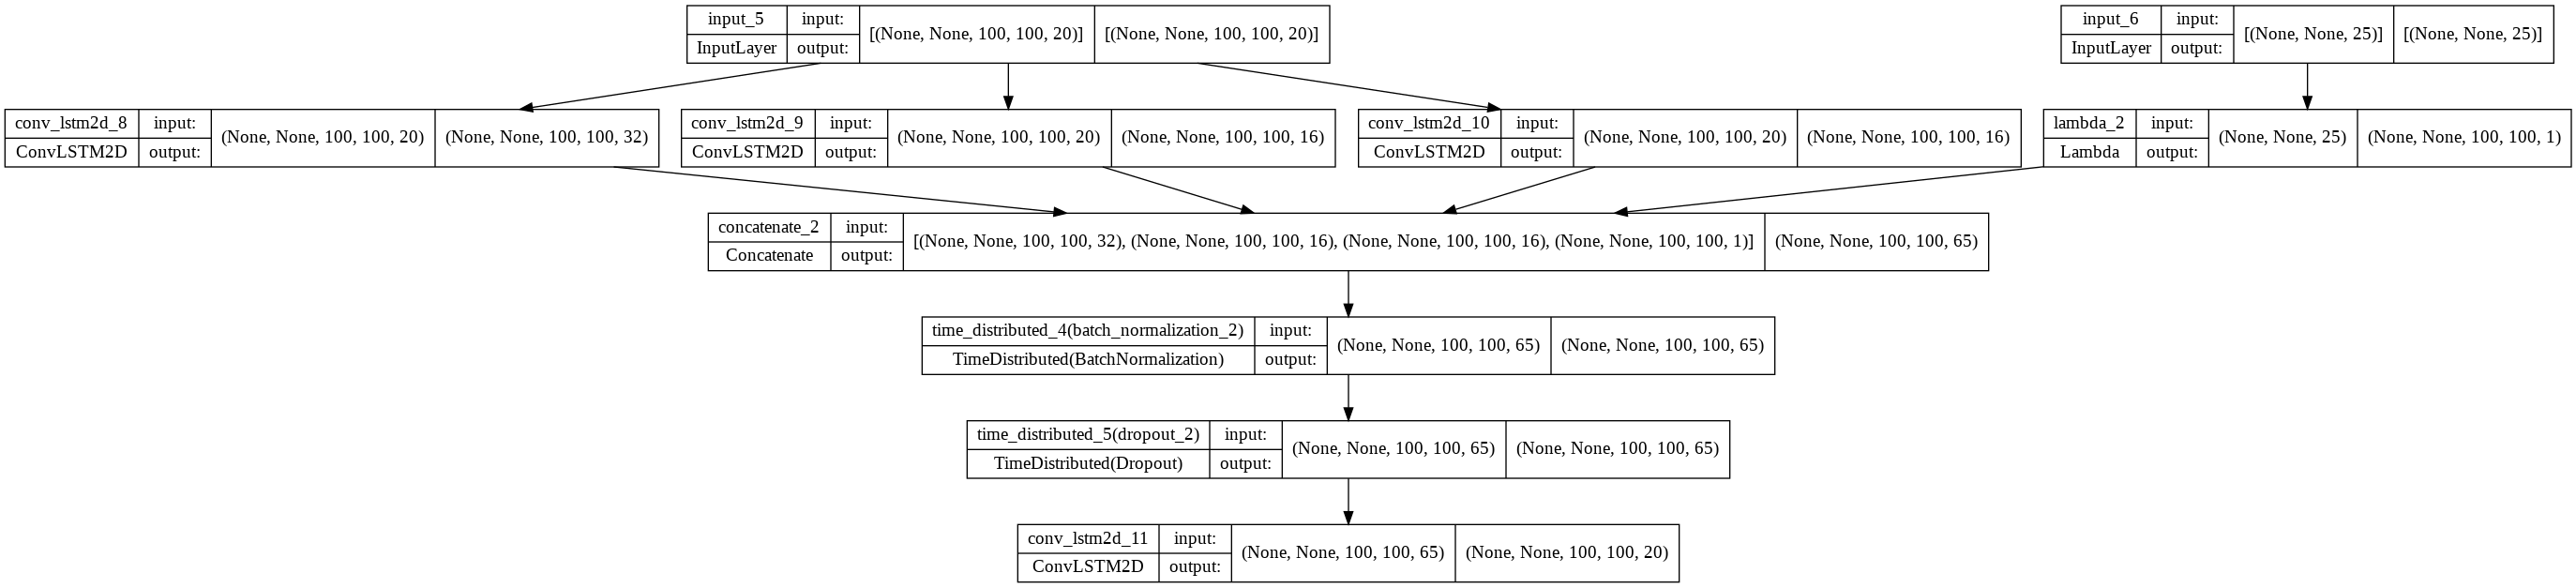

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Train model**

In [ ]:
# Collect garbage
import gc
gc.collect()

14924

In [ ]:
# Custom scheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)
# reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 4

# Fit the model to the training data.
history = model.fit(
    x= [x_train, x_mtrain],
    y= [y_train, y_mtrain],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([x_val, x_mval], y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
True shape: (None, 23, 100, 100, 20)
Pred shape: (None, 23, 100, 100, 20)
True shape: (None, 23, 100, 100, 20)
Pred shape: (None, 23, 100, 100, 20)
58/58 [==============================] - ETA: 0s - loss: 15.6319True shape: (None, 23, 100, 100, 20)
Pred shape: (None, 23, 100, 100, 20)
58/58 [==============================] - 56s 836ms/step - loss: 15.6319 - val_loss: 9.3315 - lr: 0.0010
Epoch 2/10
58/58 [==============================] - 42s 726ms/step - loss: 3.8791 - val_loss: 2.5238 - lr: 0.0010
Epoch 3/10
58/58 [==============================] - 42s 724ms/step - loss: 2.0594 - val_loss: 1.9373 - lr: 0.0010
Epoch 4/10
58/58 [==============================] - 42s 723ms/step - loss: 1.7597 - val_loss: 1.8126 - lr: 0.0010
Epoch 5/10
58/58 [==============================] - 42s 723ms/step - loss: 1.6939 - val_loss: 1.7950 - lr: 0.0010
Epoch 6/10
58/58 [==============================] - 42s 724ms/step - loss: 1.6771 - val_loss: 1.7883 - lr: 0.0010
Epoch 7/10
58/58 [===========

# Metrics and Visualization

**Loss vs Epochs**

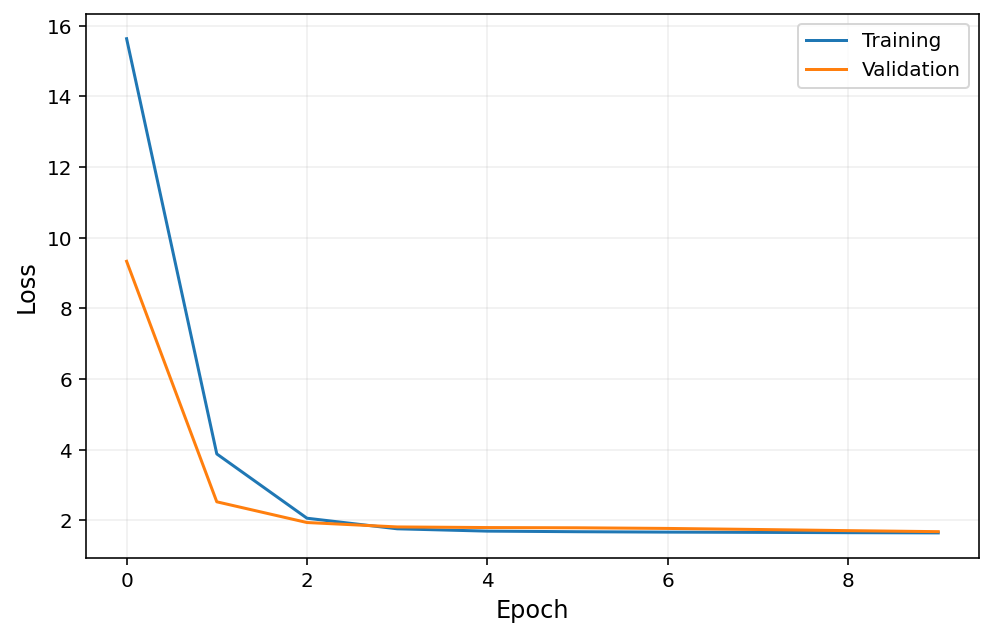

In [ ]:
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('', fontweight='bold')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['Training', 'Validation'], loc='upper right')
plt.axis('on')
plt.grid('on', alpha=.2)
plt.show()

**Compare truth vs prediction**

In [ ]:
# Flattens multichannel array
def flatten_array(input_array):
  len_array = input_array.shape[-1]
  levels_array = []
  for i in range(0, len_array):
    level = input_array[:, :, i]*((i+1)/len_array)
    levels_array.append(level)
  
  levels_array = np.array(levels_array)
  levels_array = np.moveaxis(levels_array, 0, -1)

  return np.amax(levels_array, axis=2)

SARMSE ConvLSTM Prediction: 0.08251458247483266
SARMSE Average Prediction: 0.07550745774798748
Original Max: 0.5
Predicted Max: 1.0


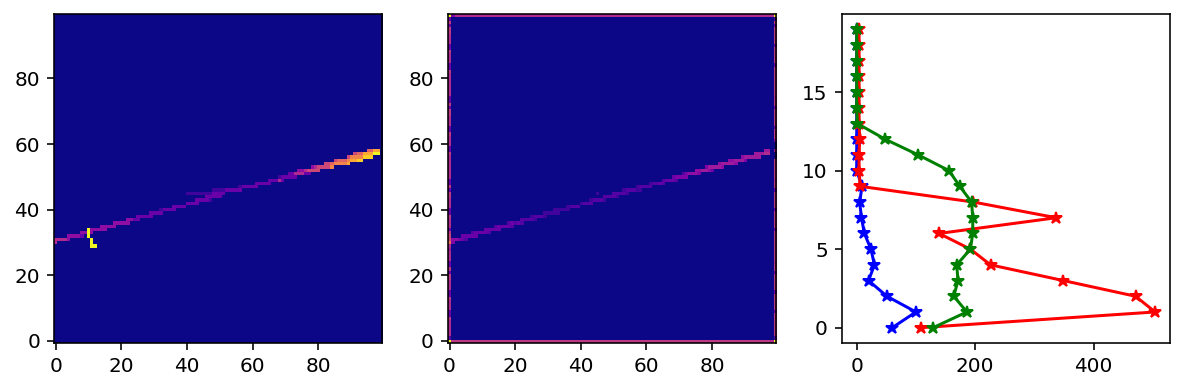

In [ ]:
# Select a random example from the validation dataset.
day = 0
hour = 0
example = x_test[day]
mexample = x_mtest[day]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
mframes = mexample[:10, ...]
original_frames = example[10:, ...]

new_prediction = model.predict([np.expand_dims(frames, axis=0), np.expand_dims(mframes, axis=0)])
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
predicted_frame = np.where(predicted_frame > 0, 1, 0)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(131)
ax1.imshow(flatten_array(original_frames[hour]), origin='lower', cmap = plt.get_cmap('plasma')) #, vmin=0, vmax=max_plot_value)

ax2 = fig.add_subplot(132)
ax2.imshow(flatten_array(predicted_frame[0]), origin='lower', cmap = plt.get_cmap('plasma')) #, vmin=0, vmax=max_plot_value)

original_level_count = []
for i in range(0, 20):
  original_level_count.append(np.count_nonzero(original_frames[hour][:,:,i]))

predicted_level_count = []
for i in range(0, 20):
  predicted_level_count.append(np.count_nonzero(predicted_frame[0][:,:,i]))

average_level_count = []
for i in range(0, 20):
  average_level_count.append(np.count_nonzero(flights_average[:,:,i]))

ax3 = fig.add_subplot(133)
ax3.plot(original_level_count, np.linspace(0, 19, 20), 'b*-')
ax3.plot(predicted_level_count, np.linspace(0, 19, 20), 'r*-')
ax3.plot(average_level_count, np.linspace(0, 19, 20), 'g*-')

asp = np.diff(ax3.get_xlim())[0] / np.diff(ax3.get_ylim())[0]
ax3.set_aspect(asp)

# print(f'SARMSE Null Prediction: {SARMSE(original_frames[0], np.zeros((100,100,20)))}')
print(f'SARMSE ConvLSTM Prediction: {SARMSE(original_frames[hour], predicted_frame[0])}')
print(f'SARMSE Average Prediction: {SARMSE(original_frames[hour], flights_average)}')
print(f'Original Max: {np.max(flatten_array(original_frames[hour]))}')
print(f'Predicted Max: {np.max(flatten_array(predicted_frame[0]))}')